# Compare sPlotOpen and iNaturalist trait maps

We will create trait maps with the iNaturalist observation data and evaluate the maps using the sPlotOpen data.

This section covers:

- Load Data
- Visualizing the trait maps - a first look
- Grid mean trait values at different resolutions
- Calculate weighted r
- Determine slope of correlation
- Plot correlation plots at 2 degree resolution

In [1]:
# packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
import geopandas as gpd

from pyproj import Proj # allows for different projections 
from shapely.geometry import shape # for calculating areas

## Load Data

In [4]:
iNat_TRY = pd.read_csv("iNat_TRY_log.csv")
iNat_TRY.head(2)

,gbifID,scientificName,decimalLatitude,decimalLongitude,eventDate,dateIdentified,Dispersal unit length,Leaf Area,SLA,Leaf C,...,Leaf delta15N,Leaf N P ratio,Leaf P,Plant Height,Seed mass,Seed length,Seeds per rep. unit,Stem conduit density,SSD,Conduit element length
0,1229615436,Commelina communis,35.987483,-79.057546,2013-07-07T00:00:00,2013-07-07T20:33:11,NaN,NaN,NaN,NaN,...,NaN,2.5362,0.536493,NaN,2.13771,NaN,NaN,NaN,NaN,NaN
1,3384000233,Commelina communis,42.093762,-75.923660,2021-08-23T13:06:06,2021-09-17T21:15:37,NaN,NaN,NaN,NaN,...,NaN,2.5362,0.536493,NaN,2.13771,NaN,NaN,NaN,NaN,NaN


In [ ]:
sPlot = pd.read_csv("sPlotOpen/cwm_loc.csv")

In [6]:
sPlot.head(2)

,PlotObservationID,TraitCoverage_cover,Species_richness,TraitCoverage_pa,Leaf Area,SSD,SLA,Leaf C,Leaf N per mass,Leaf P,...,Height_shrubs_lowest,Height_herbs_average,Height_herbs_lowest,Height_herbs_highest,SoilClim_PC1,SoilClim_PC2,Resample_1,Resample_2,Resample_3,Resample_1_consensus
0,16,0.277778,3,0.333333,3.678311,-1.047293,2.890748,6.128157,2.873263,1.114036,...,NaN,NaN,NaN,NaN,-3.66,0.546,True,False,False,True
1,17,0.038462,2,0.500000,3.678311,-1.047293,2.890748,6.128157,2.873263,1.114036,...,NaN,NaN,NaN,NaN,-3.66,0.546,True,False,False,True


## Visualize trait maps

In [5]:
def plot_grid(df, lon, lat, variable, dataset_name, deg, log=True):

    plt.rcParams.update({'font.size': 15})

    # define raster shape for plotting
    step = int((360/deg) + 1)
    bins_x = np.linspace(-180,180,step) 
    bins_y= np.linspace(-90,90,int(((step - 1)/2)+1))


    df['x_bin'] = pd.cut(df[lon], bins=bins_x)
    df['y_bin'] = pd.cut(df[lat], bins=bins_y)

    df['x_bin'] = df['x_bin'].apply(lambda x: x.left)
    df['y_bin'] = df['y_bin'].apply(lambda x: x.left)

    grouped_df = df.groupby(['x_bin', 'y_bin'], as_index=False)[variable].mean()
    raster = grouped_df.pivot('y_bin', 'x_bin', variable)

    # data format
    data_crs = ccrs.PlateCarree()
    
    #for colorbar
    levels = MaxNLocator(nbins=15).tick_values(grouped_df[variable].min(), grouped_df[variable].max())
    cmap = plt.get_cmap('YlGnBu') # colormap
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True) 
    im_ratio = raster.shape[0]/raster.shape[1] # for size of colorbar

    #create base plot of a world map
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson()) # I used the PlateCarree projection from cartopy
    ax.set_global()
        
    #add grid with values
    im = ax.pcolormesh(bins_x, bins_y, raster, cmap="YlGnBu", 
                       vmin=grouped_df[t].min(),
                       vmax=grouped_df[t].max(),
                       transform=data_crs) 
    
    #add color bar
    if log==True:
            label= "log " + str(t)
    else:
        label= str(t)
    
    fig.colorbar(im,fraction=0.046*im_ratio, pad=0.04, label=label)

    #add coastlines
    ax.coastlines(resolution='110m', color='pink', linewidth=1.5)

    #set title
    ax.set_title( variable + ' ' + dataset_name, size=14)



To visualize the trait maps we use the custom function ```plot_grid()```.

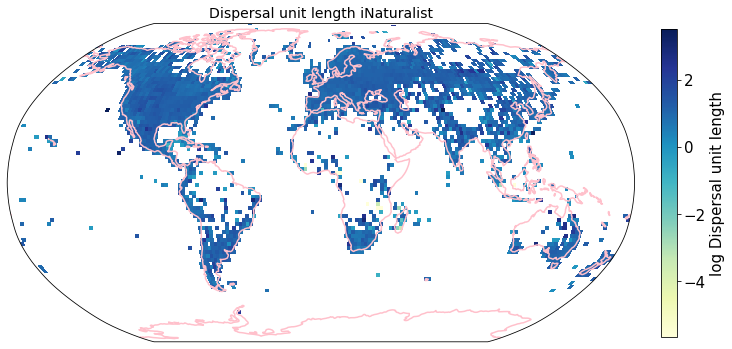

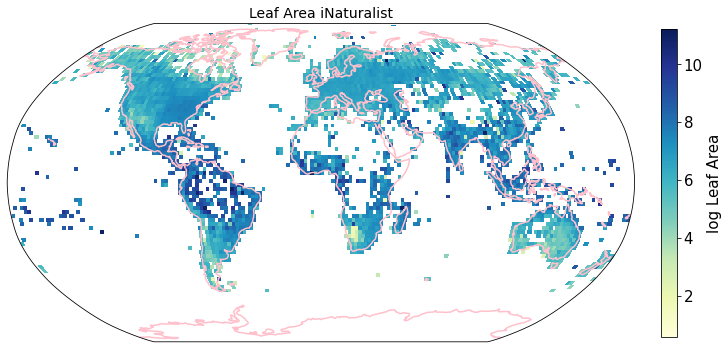

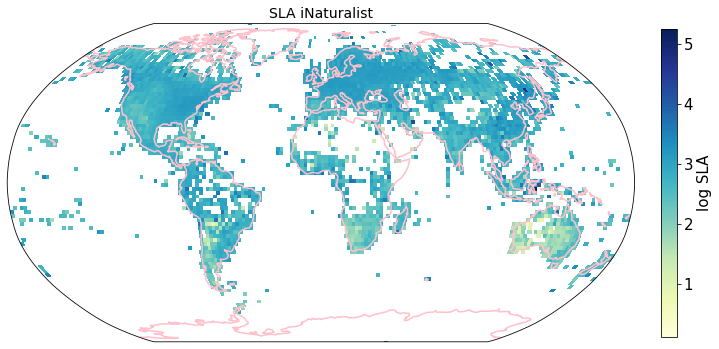

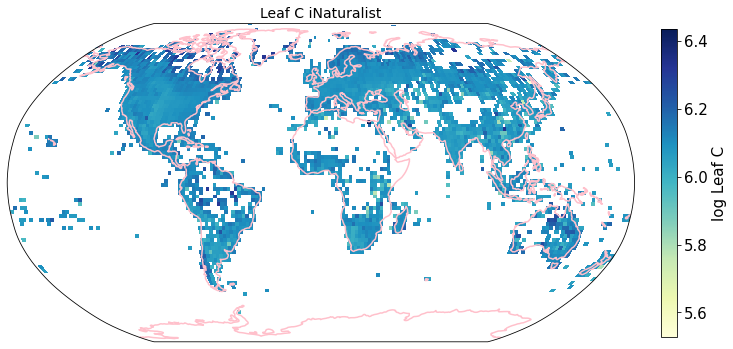

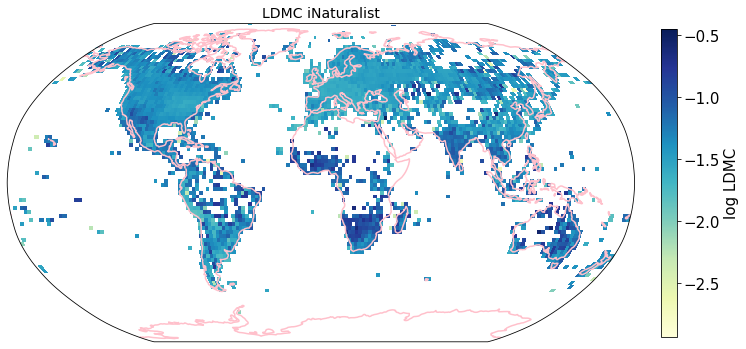

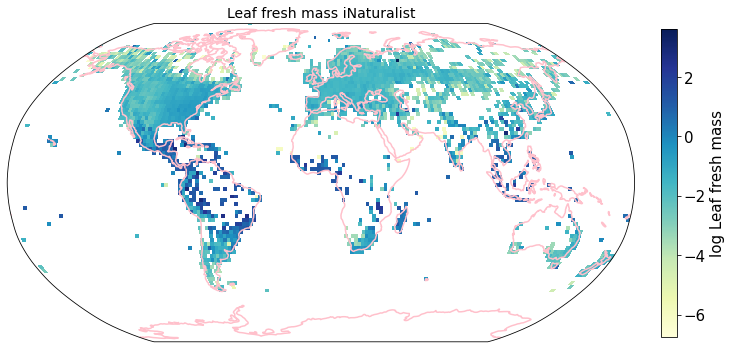

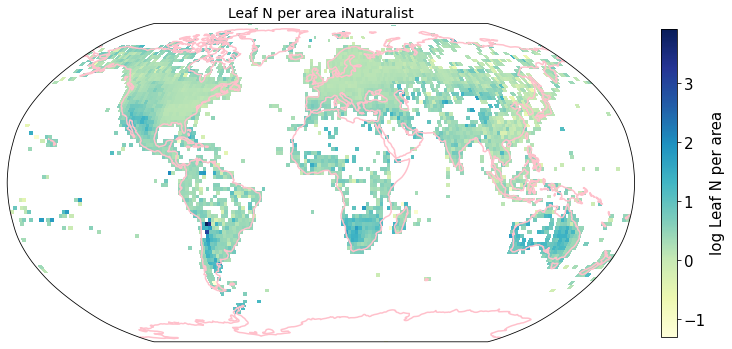

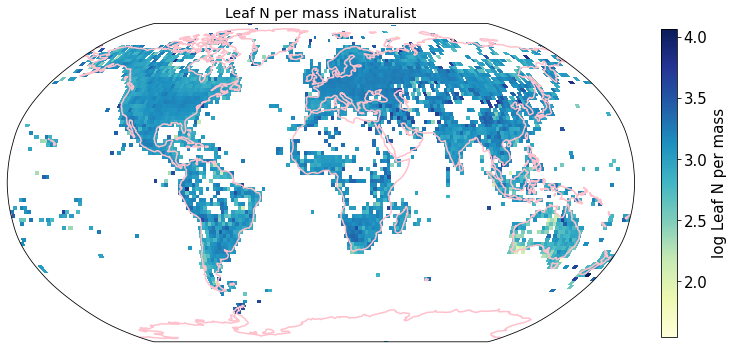

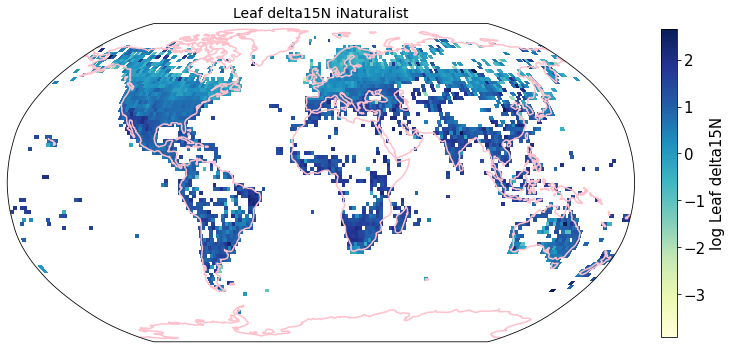

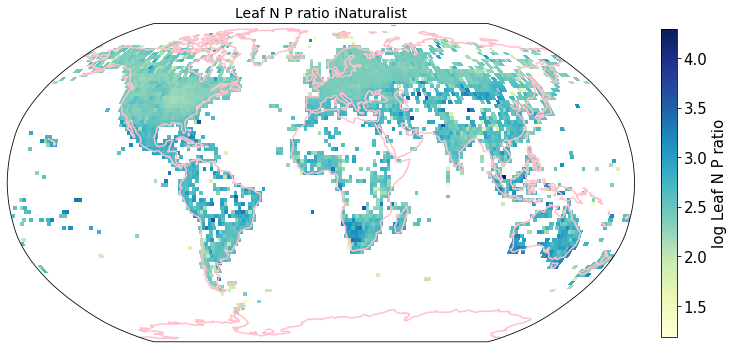

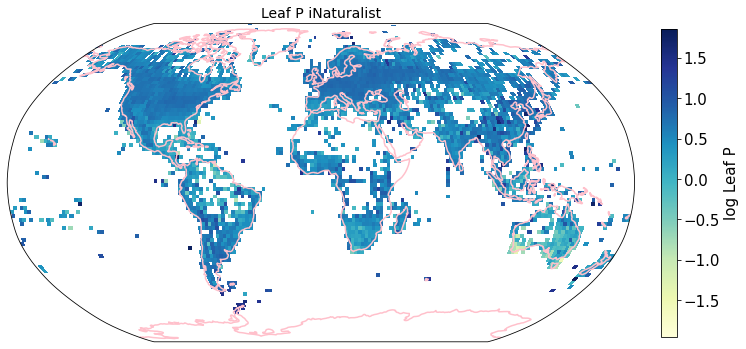

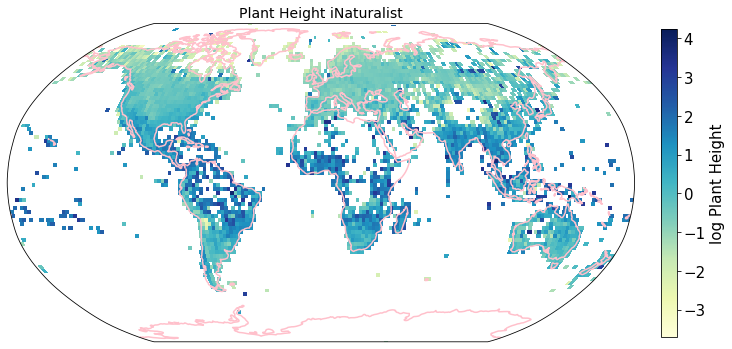

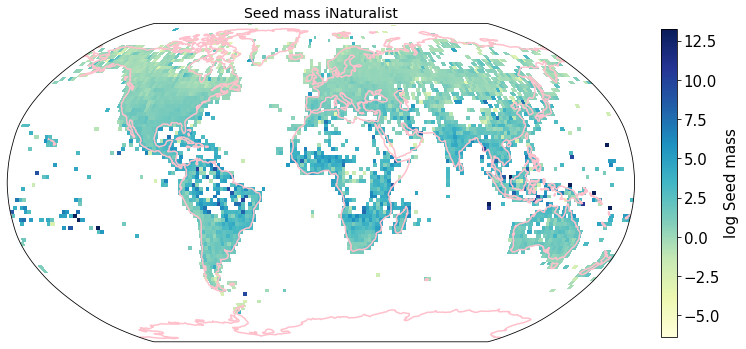

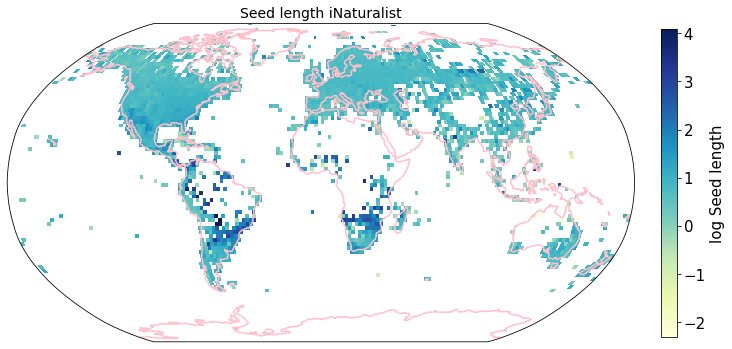

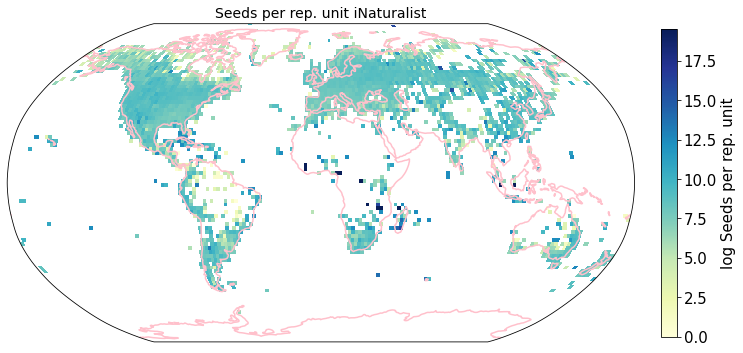

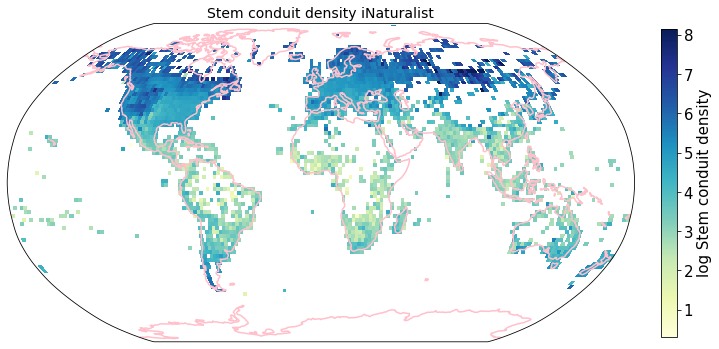

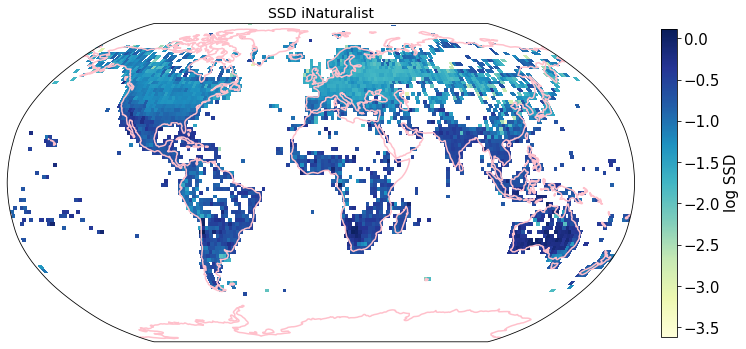

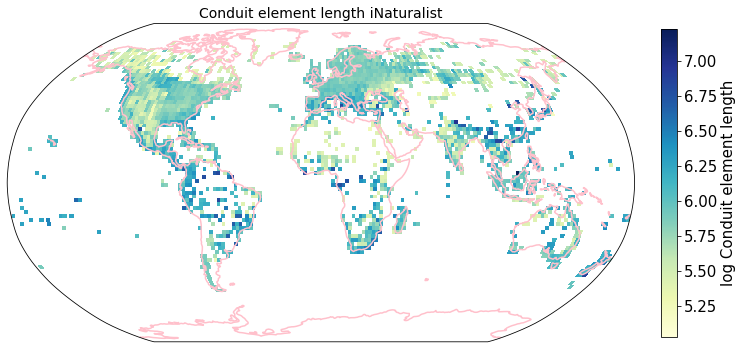

In [6]:
trait = iNat_TRY.columns[6:24]

for t in trait:

    fig = plt.figure(figsize=(12, 12))
    filename = '../Figures/iNat_traitmap_' + t +'.pdf'
    plot_grid(iNat_TRY, "decimalLongitude", "decimalLatitude",variable=t, dataset_name="iNaturalist", deg=2)
    plt.savefig(filename, bbox_inches='tight')

### Compare to maps created using R ```raster```: Load traitmaps from geotiff data

In [7]:
from os import listdir
from os.path import isfile, join
path = "./iNaturalist_traits-main/iNat_log/"
files = [f for f in listdir(path) if isfile(join(path, f))]
files.sort()

In [8]:
import xarray as xr

In [9]:
files

['iNat_Conduit.element.length_2_ln.tif',
 'iNat_Dispersal.unit.length_2_ln.tif',
 'iNat_LDMC_2_ln.tif',
 'iNat_Leaf.Area_2_ln.tif',
 'iNat_Leaf.C_2_ln.tif',
 'iNat_Leaf.N.P.ratio_2_ln.tif',
 'iNat_Leaf.N.per.area_2_ln.tif',
 'iNat_Leaf.N.per.mass_2_ln.tif',
 'iNat_Leaf.P_2_ln.tif',
 'iNat_Leaf.delta15N_2_ln.tif',
 'iNat_Leaf.fresh.mass_2_ln.tif',
 'iNat_Plant.Height_2_ln.tif',
 'iNat_SLA_2_ln.tif',
 'iNat_SSD_2_ln.tif',
 'iNat_Seed.length_2_ln.tif',
 'iNat_Seed.mass_2_ln.tif',
 'iNat_Seeds.per.rep..unit_2_ln.tif',
 'iNat_Stem.conduit.density_2_ln.tif']

In [10]:
def cubeFile(file):
    name = file.replace(".tif","")
    sr = xr.open_dataset(path + file,engine = "rasterio",chunks = 1024).sel(band = 1)
    sr = sr.assign_coords({"variable":name})
    return sr

da = xr.concat([cubeFile(x) for x in files],dim = "variable")

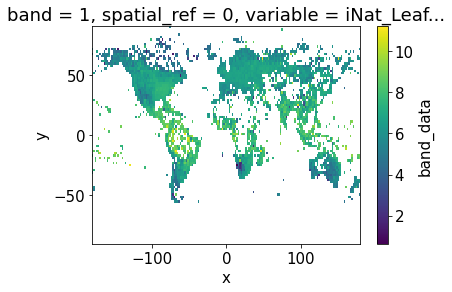

In [11]:
da.band_data.sel(variable = "iNat_Leaf.Area_2_ln").plot.imshow()

Plot one band of multidimensional xarray:

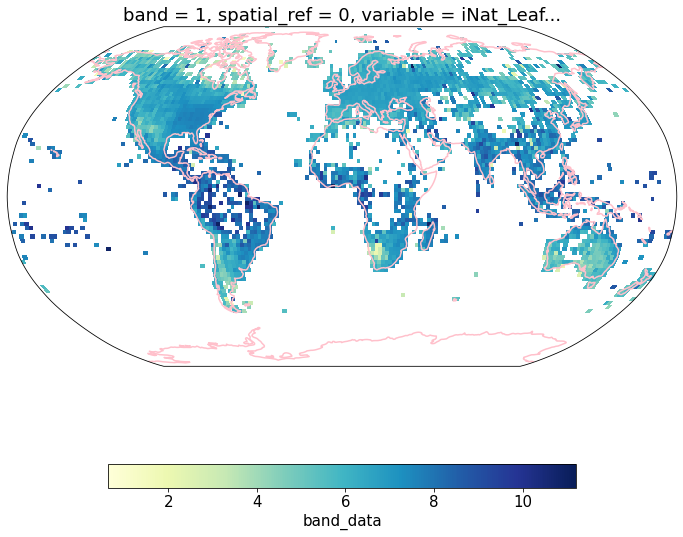

In [12]:
fig = plt.figure(figsize=(12, 12))

axis = fig.subplots(
    1, 1, subplot_kw=dict(projection=ccrs.Robinson())
)

variable = "iNat_Leaf.Area_2_ln"
im= da.band_data.sel(variable = variable).plot.pcolormesh(
    ax=axis,
    transform=ccrs.PlateCarree(),  # this is important!
    # usual xarray stuff
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.7},
    cmap='YlGnBu',
    #vmin=da.band_data.sel(variable = "iNat_Conduit.element.length").min(),
    #vmax=da.band_data.sel(variable = "iNat_Conduit.element.length").max(),
    #norm=LogNorm()

)

axis.coastlines(resolution='110m', color='pink', linewidth=1.5)  # cartopy function
#plt.tight_layout()

In [13]:
df = da.band_data.to_dataset().to_dataframe().reset_index()

In [14]:
df.head()

,x,y,variable,band,spatial_ref,band_data
0,-179.0,89.0,iNat_Conduit.element.length_2_ln,1,0,NaN
1,-179.0,89.0,iNat_Dispersal.unit.length_2_ln,1,0,NaN
2,-179.0,89.0,iNat_LDMC_2_ln,1,0,NaN
3,-179.0,89.0,iNat_Leaf.Area_2_ln,1,0,NaN
4,-179.0,89.0,iNat_Leaf.C_2_ln,1,0,NaN


In [15]:
df_spread = df.pivot(index= ['x','y'],columns='variable',values='band_data').reset_index()

In [16]:
df_spread.head()

variable,x,y,iNat_Conduit.element.length_2_ln,iNat_Dispersal.unit.length_2_ln,iNat_LDMC_2_ln,iNat_Leaf.Area_2_ln,iNat_Leaf.C_2_ln,iNat_Leaf.N.P.ratio_2_ln,iNat_Leaf.N.per.area_2_ln,iNat_Leaf.N.per.mass_2_ln,iNat_Leaf.P_2_ln,iNat_Leaf.delta15N_2_ln,iNat_Leaf.fresh.mass_2_ln,iNat_Plant.Height_2_ln,iNat_SLA_2_ln,iNat_SSD_2_ln,iNat_Seed.length_2_ln,iNat_Seed.mass_2_ln,iNat_Seeds.per.rep..unit_2_ln,iNat_Stem.conduit.density_2_ln
0,-179.0,-89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-179.0,-87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-179.0,-85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-179.0,-83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-179.0,-81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_spread.shape

(16200, 20)

## Grid mean trait values at different resolutions

In [18]:
def global_grid_data(df, long, lat, deg, variables):
    
    # create new dataframe to save the average value of each grid cell and variable
    grouped_df = pd.DataFrame()
    
    # convert degree into step size
    step = int((360/deg) + 1)
    
    bins_x = np.linspace(-180,180,step) 
    bins_y= np.linspace(-90,90,int(((step - 1)/2)+1))
    
    # group latitude and longitude coordinates into bins
    # create new columns 'x_bin' and 'y_bin'
    df['x_bin'] = pd.cut(df[long], bins=bins_x)
    df['y_bin'] = pd.cut(df[lat], bins=bins_y)
    
    # raster coordinates are in center of raster cell
    df['x_bin'] = df['x_bin'].apply(lambda x: ((x.left + x.right) /2) )
    df['y_bin'] = df['y_bin'].apply(lambda x: ((x.left + x.right) /2) )
    
    grouped_df = df.drop_duplicates(subset=['x_bin', 'y_bin'], keep='last')
    grouped_df = grouped_df[['x_bin', 'y_bin']]
    
    for v in variables:
        
        sub_df = df[['y_bin', 'x_bin', v]]
        grouped_v = sub_df.groupby(['x_bin', 'y_bin'], as_index=False)[v].mean()
        
        
        grouped_df = pd.merge(grouped_df, grouped_v, 
                    on= ['x_bin', 'y_bin'], 
                    how='left')
        
    return grouped_df

### Check function at 2 degree resolution

To create a dataframe with all traits and the mean log trait values per cell we call ```global_grid_data()```.

In [19]:
deg = 2

trait = iNat_TRY.columns[6:24]

df_iNat = global_grid_data(iNat_TRY, 'decimalLongitude', 'decimalLatitude', deg, trait)

df_iNat_t = df_iNat.melt(id_vars=["x_bin", "y_bin"], 
                     value_name="TraitValue_iNat", 
                     var_name="Trait")

In [20]:
df_iNat_t

,x_bin,y_bin,Trait,TraitValue_iNat
0,-85.0,5.0,Dispersal unit length,NaN
1,-49.0,61.0,Dispersal unit length,0.893636
2,-173.0,69.0,Dispersal unit length,0.893636
3,1.0,31.0,Dispersal unit length,0.388658
4,37.0,39.0,Dispersal unit length,1.189367
...,...,...,...,...
69313,23.0,-33.0,Conduit element length,6.299584
69314,147.0,-43.0,Conduit element length,6.089187
69315,-117.0,33.0,Conduit element length,5.760924
69316,115.0,23.0,Conduit element length,5.893173


In [21]:
df_iNat_t['Trait'].nunique()

18

### Calculate averages for different resolutions

We now compute these global grids for various grid sizes (in degrees) and all traits. We merge iNat and sPlot into one dataframe and save it.

In [ ]:
deg = [4, 2, 1, 0.5, 0.25, 0.125, 0.0625]


trait = iNat_TRY.columns[6:24]

for d in deg:
    df_iNat = global_grid_data(iNat_TRY, 'decimalLongitude', 'decimalLatitude', d, trait)
    
    df_sPlot = global_grid_data(sPlot, 'Longitude', 'Latitude', d, trait)
    
    
    # reshape data, so that we have only one Trait column
    df_iNat_t = df_iNat.melt(id_vars=["x_bin", "y_bin"], 
                     value_name="TraitValue_iNat", 
                     var_name="Trait")
    
    df_sPlot_t = df_sPlot.melt(id_vars=["x_bin", "y_bin"], 
                     value_name="TraitValue_sPlot", 
                     var_name="Trait")
    
    # merge sPlot and iNat data into one dataframe
    df_merged = pd.merge(df_sPlot_t, df_iNat_t, on=["x_bin", "y_bin", "Trait"] )
    
    # keep only lines where we have a pixel in both datasets
    df_merged = df_merged.dropna()
    
    
    # save result to csv
    filename="grid_means_" + str(d) + "_deg.csv"
    df_merged.to_csv(filename, index=False)
    

## Calculate weighted r

Calculate weights per grid cell area and weighted r for all traits and all grid sizes.

In [84]:
def lat_weights(lat_unique, deg):
    
    from pyproj import Proj
    from shapely.geometry import shape

    # determine weights per grid cell based on longitude
    # keep only one exemplary cell at each distance from equator
    # weights per approximated area of grid size depending on distance from equator
    
    # make dictionary
    weights = dict()

    for j in lat_unique:
        
        # the four corner points of the grid cell
        
        p1 = (0 , j+(deg/2))
        p2 = (deg , j+(deg/2))
        p3 = (deg, j-(deg/2))
        p4 = (0, j-(deg/2))
        
        # Calculate polygon surface area
        # https://stackoverflow.com/questions/4681737/how-to-calculate-the-area-of-a-polygon-on-the-earths-surface-using-python
        
        # Define corner points
        co = {"type": "Polygon", "coordinates": [[p1,p2,p3,p4]]}
        lat_1=p1[1]
        lat_2=p3[1]
        lat_0=(p1[1]+p3[1])/2
        lon_0=deg/2
        
        # Caveat: Connot go accross equator
        value1 = abs(lat_1 + lat_2)
        value2 = abs((lat_1) + abs(lat_2))
        
        # if grid cell overlaps equator:
        if value1 < value2:
            
            lat_1=p1[1]
            lat_2=0
            lat_0=(p1[1]+lat_2)/2
            lon_0=deg/2
            
            # Projection equal area used: https://proj.org/operations/projections/aea.html
            projection_string="+proj=aea +lat_1=" + str(lat_1) + " +lat_2=" + str(lat_2) + " +lat_0=" + str(lat_0) + " +lon_0=" + str(lon_0) 
            lon, lat = zip(*co['coordinates'][0])
        
            pa = Proj(projection_string)
            x, y = pa(lon, lat)
            cop = {"type": "Polygon", "coordinates": [zip(x, y)]}
        
            area = (shape(cop).area/1000000)*2
        
        # if grid cell is on one side of equator:
        else:
            # Projection equal area used: https://proj.org/operations/projections/aea.html
            projection_string="+proj=aea +lat_1=" + str(lat_1) + " +lat_2=" + str(lat_2) + " +lat_0=" + str(lat_0) + " +lon_0=" + str(lon_0) 
            lon, lat = zip(*co['coordinates'][0])
        
            pa = Proj(projection_string)
            x, y = pa(lon, lat)
            cop = {"type": "Polygon", "coordinates": [zip(x, y)]}
        
            area = (shape(cop).area/1000000)

        
        # set coord to center of grid cell
        coord = j
        
        # map area to weights dictionary
        weights[coord] = area
    
    # convert area into proportion with area/max.area:
    max_area = max(weights.values())
    
    for key in weights.keys():
        
        weights[key] = weights[key]/max_area
        
    return weights

In [85]:
def weighted_r(df, col_1, col_2, col_lat, weights, r2=False):
    
    # map weights to dataframe
    df['Weights'] = df[col_lat].map(weights)
        
    # calculate weighted correlation 
    # https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.DescrStatsW.html
    import statsmodels.api as statmod
    
    d1 = statmod.stats.DescrStatsW( df[[col_1, col_2]], df['Weights'] )
        
    corr = d1.corrcoef[0][1]
    
    # optional
    # calculate r2
    if r2 == True:
        corr = corr**2
    
    return corr

In [86]:
# get trait names
filename="grid_means_" + str(2) + "_deg.csv"
raster_means = pd.read_csv(filename)
trait = raster_means["Trait"].unique()

Calculate r for all traits and a range of resolutions:

In [ ]:
# resolutions we want to calculate r for
deg = [4, 2, 1, 0.5, 0.25, 0.125, 0.0625]

r_all = pd.DataFrame(columns=trait)

for i in deg:
    
    import numpy as np
    import statsmodels.api as statmod
    
    # open saved raster mean files
    filename="grid_means_" + str(i) + "_deg.csv"
    raster_means = pd.read_csv(filename)
    raster_means = raster_means[~raster_means.isin([np.nan, np.inf, -np.inf]).any(1)]
    # determine weights per grid cell based on longitude
    
    lat_unique = raster_means['y_bin'].unique()
    weights = lat_weights(lat_unique, deg=i)
    
    # initiate  
    r_grid = []  
    
    for t in trait:
        # subset only one trait
        raster_means_trait = raster_means[raster_means['Trait']==t]
        
        # drop nan's
        raster_means_trait = raster_means_trait.dropna()
        
        # calculate weighted r
        r_trait = weighted_r(raster_means_trait, "TraitValue_sPlot", "TraitValue_iNat", "y_bin", weights)
        
        # add to trait r's
        r_grid.append(r_trait)
    
    
    s = pd.Series(r_grid, index=r_all.columns)
    
    # add new series of r at a certain resolution to df 
    r_all = r_all.append(s, ignore_index=True)

    
# add resolution to r-df
r_all['Resolution'] = [4, 2, 1, 0.5, 0.25, 0.13, 0.06]

In [88]:
r_all

,Dispersal unit length,Leaf Area,SLA,Leaf C,LDMC,Leaf fresh mass,Leaf N per area,Leaf N per mass,Leaf delta15N,Leaf N P ratio,Leaf P,Plant Height,Seed mass,Seed length,Seeds per rep. unit,Stem conduit density,SSD,Conduit element length,Resolution
0,-0.064129,0.648441,0.541325,0.313925,0.395695,0.675771,0.530652,0.410528,0.335074,0.402132,0.417266,0.573948,0.520051,0.227821,0.033105,0.694801,0.639448,0.360548,4.00
1,-0.040254,0.591867,0.559321,0.214475,0.337698,0.593019,0.592591,0.36652,0.261048,0.459257,0.3891,0.58217,0.48431,0.26135,0.061491,0.680519,0.629418,0.319216,2.00
2,-0.008955,0.528993,0.545211,0.281464,0.352232,0.518514,0.542192,0.412746,0.266304,0.425005,0.421088,0.579327,0.460602,0.272997,0.122855,0.635591,0.628607,0.313588,1.00
3,0.015484,0.443391,0.511926,0.223498,0.343284,0.426179,0.533832,0.369761,0.203682,0.356999,0.40571,0.508895,0.368398,0.250143,0.146879,0.57069,0.556945,0.278735,0.50
4,0.012678,0.386012,0.464901,0.208586,0.325511,0.313482,0.490444,0.350628,0.168444,0.292185,0.371618,0.4243,0.298729,0.196469,0.121625,0.494574,0.484192,0.240417,0.25
5,0.004708,0.325776,0.423198,0.195532,0.302716,0.2446,0.446798,0.344023,0.173674,0.272116,0.346877,0.361929,0.239897,0.172903,0.109652,0.436362,0.443396,0.200705,0.13
6,-0.006774,0.309105,0.415142,0.164298,0.308849,0.208823,0.424765,0.365924,0.195232,0.252934,0.356953,0.352254,0.236357,0.152757,0.089049,0.425663,0.415955,0.186163,0.06


Save result to ```.csv```

In [75]:
r_all.to_csv("r_all.csv", index=False)

Visualize different r at different resolutions as line graph (The straight lines connecting the dots only there to facilitate readibility):

In [56]:
r_all = pd.read_csv("r_all.csv")

Median correlation at 2 degree resolution

In [89]:
np.median(r_all.iloc[1])

0.4592574614778774

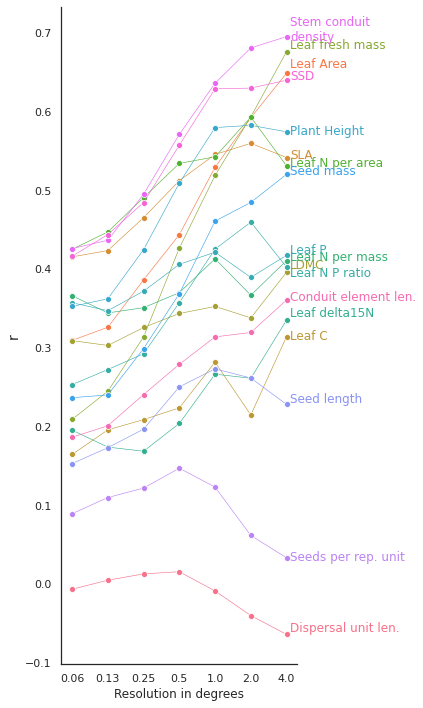

In [29]:
#### Plot 
# https://stackoverflow.com/questions/44941082/plot-multiple-columns-of-pandas-dataframe-using-seaborn

trait_names = ['Dispersal unit len.', 'Leaf Area', 'SLA', 'Leaf C', 'LDMC',
       'Leaf fresh mass', 'Leaf N per area', 'Leaf N per mass',
       'Leaf delta15N', 'Leaf N P ratio', 'Leaf P', 'Plant Height',
       'Seed mass', 'Seed length', 'Seeds per rep. unit',
       'Stem conduit \ndensity', 'SSD', 'Conduit element len.']

# data 
data_dropnan = r_all.dropna(axis=1, how='all')
data_melt= pd.melt(data_dropnan, ['Resolution'], value_name="r")

# change Resolution to string, so it is not interpreted as a number
data_melt = data_melt.astype({"Resolution": str}, errors='raise') 

# set plotting parameters
sns.set(rc={'figure.figsize':(6,10)}) # size
sns.set(font_scale = 2) # make font larger
sns.set_theme(style="white") # plain white plot, no grids

# initiate plot
fig, ax = plt.subplots()

# plot all lines into one plot

sns.lineplot(x='Resolution', 
            y='r', 
            hue='variable', 
            data=data_melt,
            ax=ax,
            marker='o',
            linewidth=0.6,
            legend=None)

label_pos=[]

# Add the text--for each line, find the end, annotate it with a label
# https://lost-stats.github.io/Presentation/Figures/line_graph_with_labels_at_the_beginning_or_end.html

for line, variable in zip(ax.lines, trait_names):
    y = line.get_ydata()[0]
    x = line.get_xdata()[0]
    if not np.isfinite(y):
        y=next(reversed(line.get_ydata()[~line.get_ydata().mask]),float("nan"))
    if not np.isfinite(y) or not np.isfinite(x):
        continue 
    x=round(x)
    y=round(y,2)
    xy=(x-0.1, y)
    if xy in label_pos:
        xy=(x-0.1, y-0.01)
    if xy in label_pos:
        xy=(x-0.1, y+0.015)
    if variable=="Seed Mass":
        xy=(x-0.1, y-0.02)
    if variable=="Leaf Area":
        xy=(x-0.1, y+0.005)
    label_pos.append(xy)
    text = ax.annotate(variable,
                       xy=(xy),
                       xytext=(0, 0),
                       color=line.get_color(),
                       xycoords=(ax.get_xaxis_transform(),
                                 ax.get_yaxis_transform()),
                       textcoords="offset points")
    text_width = (text.get_window_extent(
    fig.canvas.get_renderer()).transformed(ax.transData.inverted()).width)

# Format the date axis to be prettier.
sns.despine()
plt.xlabel("Resolution in degrees",  fontsize = 12)
plt.ylabel("r",  fontsize = 14) 

ax.invert_xaxis()

plt.tight_layout()

# save figure as pdf
plt.savefig('../Figures/r_vs_resolution_long.pdf', bbox_inches='tight')  

## Determine slope of the correlation

In [90]:
from pylr2 import regress2

Load pixel trait means at 2 degrees:

In [97]:
deg = 2
filename="grid_means_" + str(deg) + "_deg.csv"
raster_means = pd.read_csv(filename)

# remove inf. values
raster_means = raster_means[~raster_means.isin([np.nan, np.inf, -np.inf]).any(1)]

# filter only for trait means, we don't need the counts per pixel
raster_means = raster_means[raster_means['Trait'].isin(trait)]


Check method for one trait:

In [11]:
# subset only one trait
raster_means_trait = raster_means[raster_means['Trait']=="Plant Height"]
        
# drop nan's
raster_means_trait = raster_means_trait.dropna(subset = ['TraitValue_iNat', 'TraitValue_sPlot'])


In [12]:
x = raster_means_trait["TraitValue_sPlot"]
y = raster_means_trait["TraitValue_iNat"]
results = regress2(x, y, _method_type_2="reduced major axis")

In [13]:
results

{'slope': 0.7606001314977557,
 'intercept': -0.15827807085124396,
 'r': 0.5985443572644118,
 'std_slope': 0.021256591178264863,
 'std_intercept': 0.026223999235003997,
 'predict': 10519   -1.216659
 10520   -0.959619
 10521   -0.800042
 10522   -0.109246
 10523   -0.047238
            ...   
 11544   -0.731485
 11545   -0.584747
 11546   -0.868299
 11547   -0.820544
 11548   -0.791688
 Name: TraitValue_sPlot, Length: 1030, dtype: float64}

In [14]:
slope_boot = []

for i in range(0,3000):
    sample_df = raster_means_trait.sample(n=len(raster_means_trait), replace=True, axis=0)
    
    x = sample_df["TraitValue_sPlot"]
    y = sample_df["TraitValue_iNat"]

    results = regress2(x, y, _method_type_2="reduced major axis")
    slope_boot.append(results["slope"])
    
    

In [15]:
np.quantile(slope_boot,0.05)

0.7271391098609535

In [16]:
np.quantile(slope_boot,0.95)

0.7941371924153917

For all traits:

In [17]:
slopes = pd.DataFrame(index=['slope','intercept','conf_int'])

for t in trait:
    # subset only one trait
    raster_means_trait = raster_means[raster_means['Trait']==t]
        
    # drop nan's
    raster_means_trait = raster_means_trait.dropna(subset = ['TraitValue_iNat', 'TraitValue_sPlot'])
    
    # filter out outliers
    cols = ['TraitValue_iNat', 'TraitValue_sPlot'] # one or more
    
    Q1 = raster_means_trait[cols].quantile(0.01)
    Q3 = raster_means_trait[cols].quantile(0.99)
    IQR = Q3 - Q1

    raster_means_trait = raster_means_trait[~((raster_means_trait[cols] < (Q1 - 1.5 * IQR)) |(raster_means_trait[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    
    x = raster_means_trait["TraitValue_sPlot"]
    y = raster_means_trait["TraitValue_iNat"]
    
    results = regress2(x, y, _method_type_2="reduced major axis")
        
    slope = results["slope"]
    intercept = results["intercept"]
    
    # get 95% confidence interval
    
    slope_boot = []
    
    for i in range(0,3000):
        sample_df = raster_means_trait.sample(n=len(raster_means_trait), replace=True, axis=0)
    
        x = sample_df["TraitValue_sPlot"]
        y = sample_df["TraitValue_iNat"]

        results = regress2(x, y, _method_type_2="reduced major axis")
        slope_boot.append(results["slope"])
    
    conf_int = [round(np.quantile(slope_boot,0.05),2), round(np.quantile(slope_boot,0.95),2)] # 95% conf_interval
    
    slopes[t] = [slope, intercept, conf_int]


In [18]:
slopes

,Dispersal unit length,Leaf Area,SLA,Leaf C,LDMC,Leaf fresh mass,Leaf N per area,Leaf N per mass,Leaf delta15N,Leaf N P ratio,Leaf P,Plant Height,Seed mass,Seed length,Seeds per rep. unit,Stem conduit density,SSD,Conduit element length
slope,0.882832,1.027592,1.414497,1.238462,1.0617,1.129783,1.392226,1.0775,2.007867,1.147387,1.290807,0.7606,0.841936,1.279172,1.351475,1.435743,2.574361,0.987289
intercept,-0.111272,0.160015,-0.934332,-1.486539,-0.207463,0.67872,-0.126172,-0.082166,-0.464251,-0.375518,0.027418,-0.158278,0.417664,-0.642623,0.0792,-1.459013,0.914904,-0.002103
conf_int,"[-0.94, 0.97]","[0.97, 1.08]","[1.34, 1.49]","[1.12, 1.37]","[0.99, 1.14]","[1.07, 1.19]","[1.32, 1.47]","[1.01, 1.15]","[1.89, 2.14]","[1.08, 1.22]","[1.2, 1.38]","[0.73, 0.79]","[0.79, 0.9]","[1.14, 1.42]","[1.18, 1.53]","[1.38, 1.5]","[2.47, 2.69]","[0.92, 1.07]"


Calculate SMA stats in R:

```
library(smatr)

iNat <- read.csv("grid_means_2_deg.csv")

traits <- unique(iNat$Trait)

test <- data.frame()

for (t in 1:length(traits)){
      sub <- iNat[iNat$Trait == traits[[t]],]
      results <- sma(TraitValue_iNat~TraitValue_sPlot, data=sub, slope.test=1, elev.test=0)
      coef <- data.frame(results$coef)
      ci <- data.frame(traits[[t]], coef$coef.SMA.[1], coef$coef.SMA.[2], coef$lower.limit[2], coef$upper.limit[2], results$slopetest[[1]]$p)
      test <- rbind(test,ci)}

write.csv(test, "sma_stats.csv")

```


In [54]:
slopes = pd.read_csv("sma_stats.csv")

In [55]:
slopes.set_index(slopes["traits..t.."], inplace=True)

In [56]:
slopes.drop(["Unnamed: 0", "traits..t.."], axis=1, inplace=True)

In [58]:
slopes = slopes.transpose()


In [63]:
slopes.index = list(["intercept", "slope", "ci_lower", "ci_upper", "p"])


In [91]:
slopes

traits..t..,Dispersal unit length,Leaf Area,SLA,Leaf C,LDMC,Leaf fresh mass,Leaf N per area,Leaf N per mass,Leaf delta15N,Leaf N P ratio,Leaf P,Plant Height,Seed mass,Seed length,Seeds per rep. unit,Stem conduit density,SSD,Conduit element length
intercept,2.501463,0.160015,-0.934332,-1.486539e+00,-0.207463,0.678720,-0.126172,-0.082166,-0.464251,-3.755179e-01,0.027418,-0.158278,4.176638e-01,-6.426235e-01,0.079200,-1.459013,0.914904,-0.002103
slope,-1.137526,1.027592,1.414497,1.238462e+00,1.061700,1.129783,1.392226,1.077500,2.007867,1.147387e+00,1.290807,0.760600,8.419362e-01,1.279172e+00,1.351475,1.435743,2.574361,0.987289
ci_lower,-1.215182,0.976077,1.343843,1.165017e+00,1.000283,1.067211,1.324024,1.017220,1.885989,1.086091e+00,1.219092,0.724223,7.991787e-01,1.200008e+00,1.265306,1.369064,2.452730,0.924341
ci_upper,-1.064833,1.081825,1.488866,1.316536e+00,1.126888,1.196024,1.463942,1.141351,2.137621,1.212142e+00,1.366740,0.798804,8.869814e-01,1.363558e+00,1.443513,1.505670,2.702024,1.054524
p,0.000133,0.299447,0.000000,8.592571e-12,0.048924,0.000028,0.000000,0.011068,0.000000,9.796284e-07,0.000000,0.000000,1.199024e-10,5.906386e-14,0.000000,0.000000,0.000000,0.703398


## Plot correlation plots for all traits at 2 degree resolution

We want to look at the scatterplots a bit closer now. The previous plot shows that we have a high correlation for a number of traits at a resolution of 2 degrees, so we choose this resolution in the following, more detailed analyses.

### Calculate axes ranges

In [99]:
# calculate max-min ranges

def min__max_ranges(df, col_1, col_2, variable_col, variables):

    range_all =[]

    for i in variables:
        df_sub = df[df[variable_col]==i]
        df_sub = df_sub.dropna(subset = [col_1, col_2])
    
        xmin = df_sub[col_1].quantile(0.01)
        xmax = df_sub[col_1].quantile(0.99)
    
        ymin = df_sub[col_2].quantile(0.01)
        ymax = df_sub[col_2].quantile(0.99)
    
    
        if xmin>ymin:
            if not np.isfinite(ymin):
                pass
            else:
                xmin = ymin
        else:
            pass
    
        if xmax<ymax:
            xmax=ymax
        else:
            pass
        
        range_sub = [xmin, xmax]
    
        range_all.append(range_sub)
        
    ranges  = pd.DataFrame()
    ranges['variable'] = variables
    ranges['min'] = [i[0] for i in range_all]
    ranges['max'] = [i[1] for i in range_all]
    ranges = ranges.set_index('variable')

    return ranges

We claculate data ranges for all traits, so that we can plot symmetrical scatterplots:


In [100]:
ranges = min__max_ranges(raster_means, 'TraitValue_sPlot', 'TraitValue_iNat', 
                         variable_col='Trait', variables=trait)


In [102]:
ranges

,min,max
variable,,
Dispersal unit length,-0.227319,2.460527
Leaf Area,3.609251,9.130945
SLA,1.285192,3.254503
Leaf C,5.980399,6.249313
LDMC,-1.831323,-0.627124
Leaf fresh mass,-4.256507,1.441722
Leaf N per area,-0.043052,1.378253
Leaf N per mass,2.360681,3.430899
Leaf delta15N,-0.969118,2.051529


Now we can plot a scatter plot for each trait in one large panel:

In [108]:
def plot_scatterplots(df, x, y, col, variables, labels, label_x, label_y, col_wrap):
    sns.set_theme(style="white", font_scale=1.5)
    
    # The relplot function can plot multiple variable in on large figure
    g = sns.relplot(
        data=df,
        x=x, y=y,
        col=col, 
        kind="scatter", 
        col_wrap=col_wrap, 
        linewidth=0,
        alpha=0.5,
        color="midnightblue",
        palette='crest',
        facet_kws={'sharey': False, 'sharex': False}
    )

    plt.subplots_adjust(hspace=0.35)
    index=0
    two = "2"
    

    # Iterate over each subplot to customize further
    for variables, ax in g.axes_dict.items():

        # Plot the 1:1 line
        ax.axline([0, 0], [1, 1], color= "black", alpha=0.6, ls = ":")
        
        # Plot the splope
        m = slopes[str(variables)].iloc[1]
        b = slopes[str(variables)].iloc[0]
        ci = [round(slopes[str(variables)].iloc[2],2), round(slopes[str(variables)].iloc[3],2)]
        # get min and max values 
        x_1 = ranges.loc[variables, "min"]
        #x_2 = ranges.loc[variables, "max"]
        ax.axline([x_1, ((m*x_1)+b)], slope=m, color='red')
        
        
        # Add the title as an annotation within the plot
        if b < 0:
            sub_title= str(labels[index])+ "\n" + "r = " + str(round(r_all.loc[1, variables], 2)) + "\n" + "y = " + str(round(m,2))   + "x - " + str(abs(round(b,2)))+ "\n95CI(m) = " + str(ci)
        else:
            sub_title= str(labels[index])+ "\n" + "r = " + str(round(r_all.loc[1, variables], 2) ) +  "\n" + "y = " + str(round(m,2)) +  "x + " + str(round(b,2))+ "\n95CI(m) = " + str(ci)
        ax.text(.05, 1, sub_title, transform=ax.transAxes)
        

        index+=1
        
    for variables, ax in g.axes_dict.items():
    # Set the axis ranges
        space = (ranges.loc[variables, "max"]-[ranges.loc[variables, "min"]]) * 0.2
        ax.set_xlim(ranges.loc[variables, "min"] - abs(space), ranges.loc[variables, "max"] + abs(space))
        ax.set_ylim(ranges.loc[variables, "min"] - abs(space), ranges.loc[variables, "max"] + abs(space))


    # Edit some supporting aspects of the plot
    g.set_titles("")
    g.set_axis_labels(label_x, label_y)
    g.tight_layout()


### Plot scatterplots for all traits

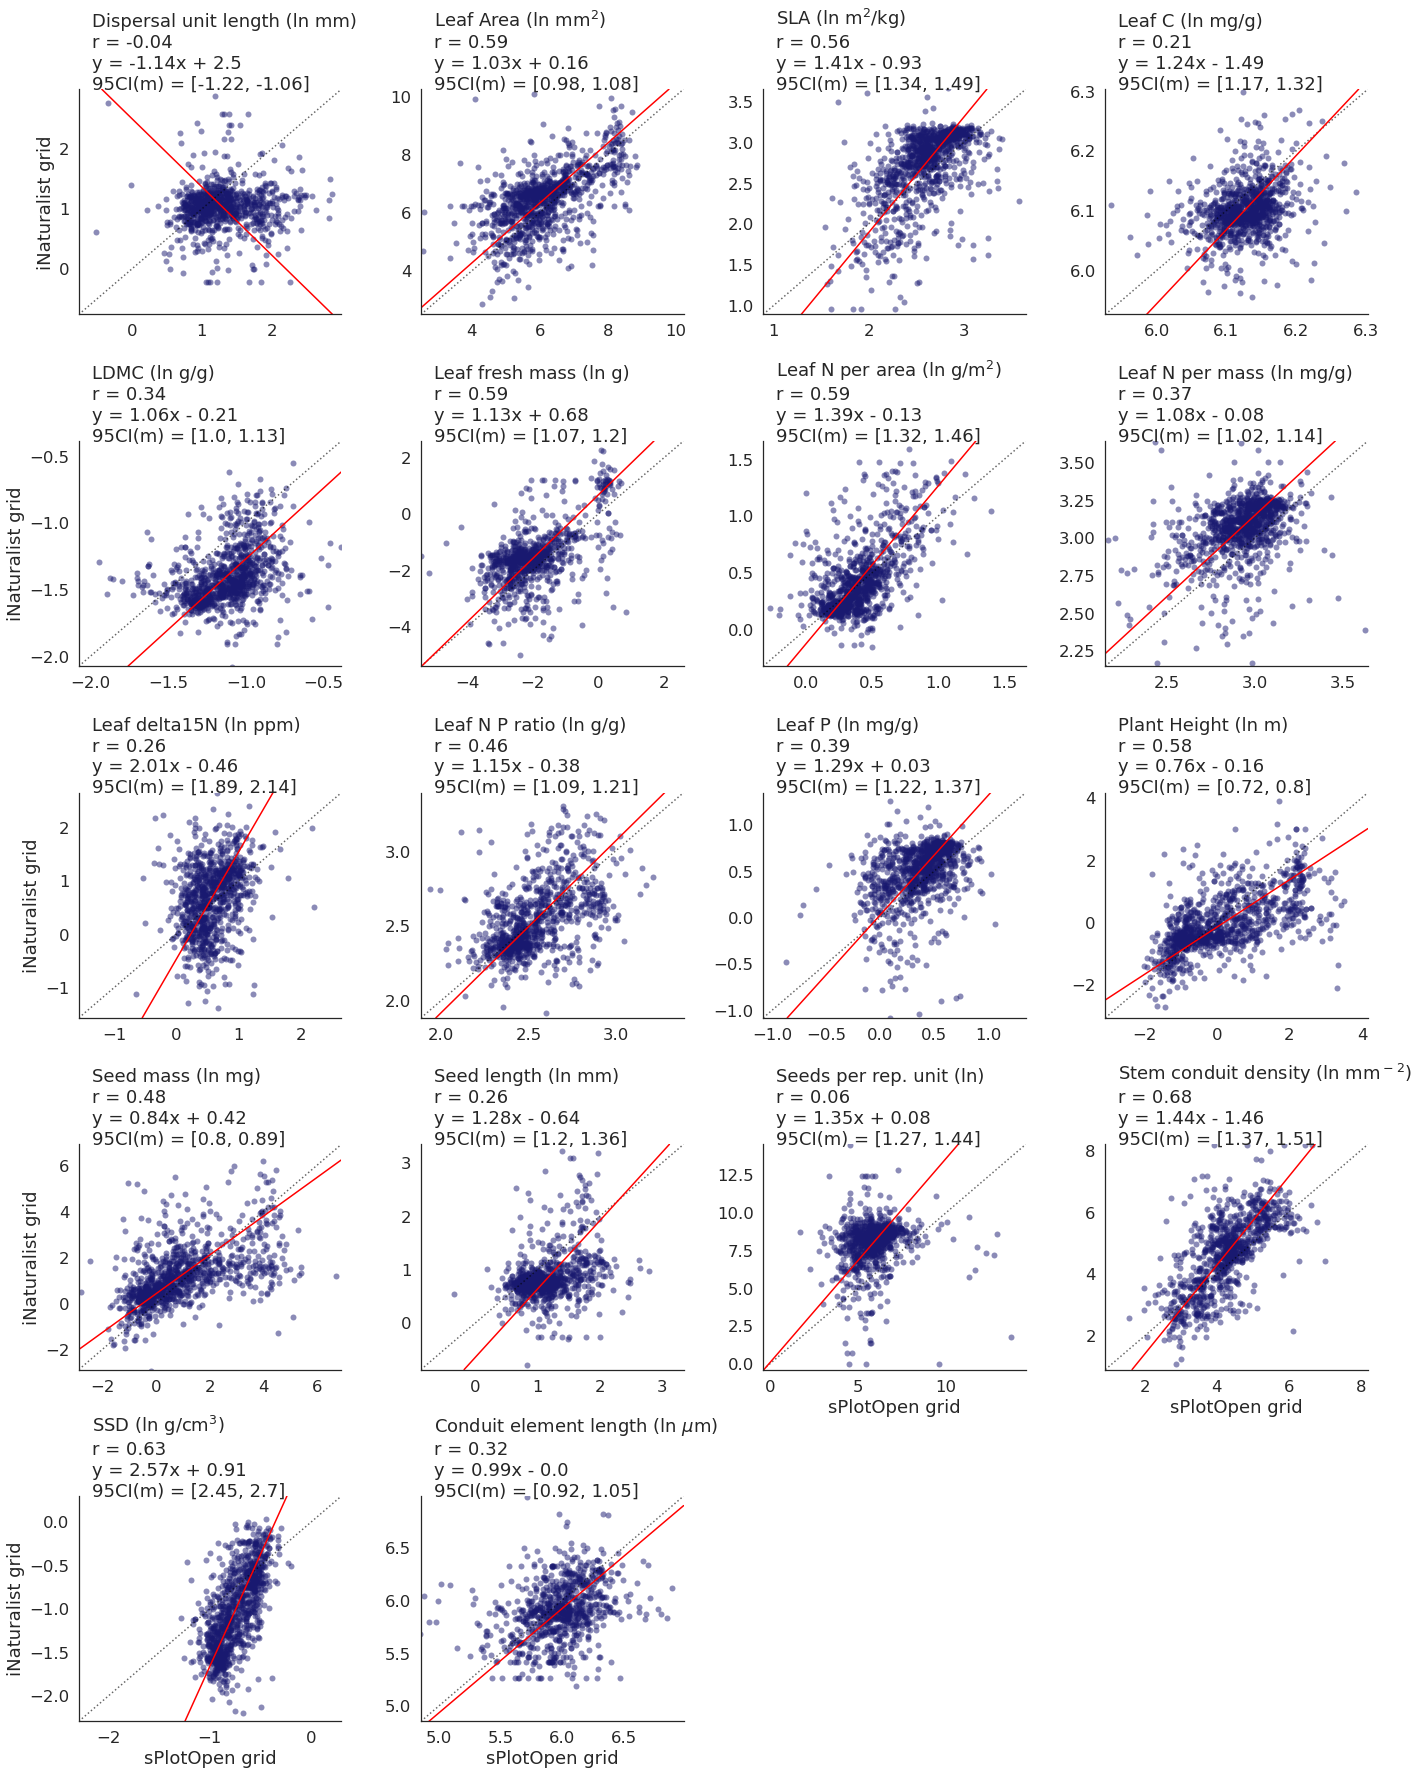

In [109]:
trait_names = ['Dispersal unit length (ln mm)', 'Leaf Area (ln mm$^2$)', 'SLA (ln m$^2$/kg)', 'Leaf C (ln mg/g)', 'LDMC (ln g/g)',
       'Leaf fresh mass (ln g)', 'Leaf N per area (ln g/m$^2$)', 'Leaf N per mass (ln mg/g)',
       'Leaf delta15N (ln ppm)', 'Leaf N P ratio (ln g/g)', 'Leaf P (ln mg/g)', 'Plant Height (ln m)',
       'Seed mass (ln mg)', 'Seed length (ln mm)', 'Seeds per rep. unit (ln)',
       'Stem conduit density (ln mm$^-$$^2$)', 'SSD (ln g/cm$^3$)', 'Conduit element length (ln $\mu$m)']


plot_scatterplots(raster_means, "TraitValue_sPlot", "TraitValue_iNat", col="Trait", 
                  variables=trait, labels=trait_names, 
                  label_x = "sPlotOpen grid", label_y = "iNaturalist grid",
                 col_wrap=4)

# Save figure
plt.savefig('../Figures/corr_plots_all_r.pdf', bbox_inches='tight')

In [96]:
raster_means

,x_bin,y_bin,Trait,TraitValue_sPlot,TraitValue_iNat
0,-148.6565,69.4065,Dispersal unit length,0.752731,1.337428
1,-144.3435,69.4690,Dispersal unit length,1.089437,0.298622
2,-136.3435,62.2810,Dispersal unit length,1.198785,0.901360
3,-148.7810,70.2810,Dispersal unit length,0.730777,0.903318
4,-148.6565,70.2810,Dispersal unit length,0.745368,0.000000
...,...,...,...,...,...
207105,12.9065,46.5935,Conduit element length,6.106800,5.954530
207106,23.5310,56.9690,Conduit element length,6.306639,6.109988
207107,23.4690,56.9690,Conduit element length,6.349083,5.981163
207108,23.3435,57.0310,Conduit element length,5.473169,5.876802


### Plot top traits only

In [106]:
# select top traits
top_trait = ['Leaf Area', 'SLA', 'Leaf fresh mass', 
               'Leaf N per area','Plant Height', 'Stem conduit density']

trait_names = ['Leaf Area (ln mm$^2$)', 'SLA (ln m$^2$/kg)', 'Leaf fresh mass (ln g)', 
               'Leaf N per area (ln g/m$^2$)','Plant Height (ln m)', 'Stem cond. density (ln mm$^-$$^2$)']

raster_means_top = raster_means[raster_means['Trait'].isin(top_trait)]

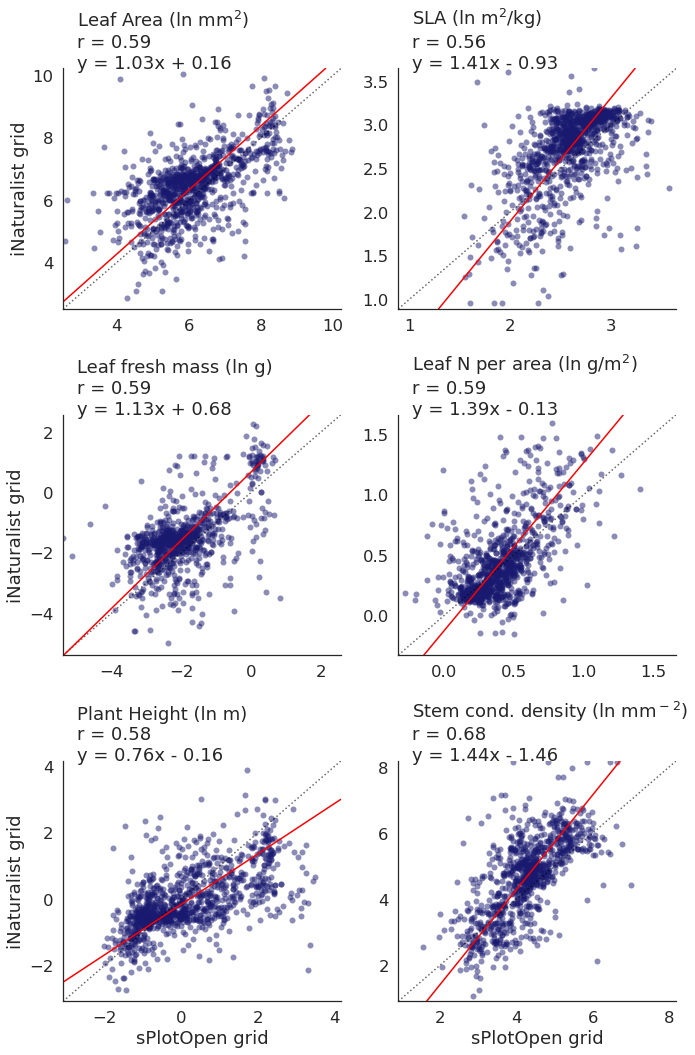

In [107]:
plot_scatterplots(raster_means_top, "TraitValue_sPlot", "TraitValue_iNat", col="Trait", 
                  variables=top_trait, labels=trait_names, 
                  label_x = "sPlotOpen grid", label_y = "iNaturalist grid", col_wrap =2)
# Save figure
plt.savefig('../Figures/corr_plots_top6.pdf', bbox_inches='tight')